# Regression Test for Gammapy Issue #1842

This notebook implements a rgression test for https://github.com/gammapy/gammapy/issues/1842

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore, EventList
from gammapy.cube.background import make_map_background_irf
from gammapy.cube import MapMaker
from gammapy.maps import Map, WcsGeom, MapAxis

Read in DC1 example data:

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
obs = data_store.obs(110380)

## Reference Background

Select background events by MC ID and apply energy as well as FoV cut:

In [4]:
is_bkg = (obs.events.table['MC_ID'] == 1)
events_bkg = EventList(obs.events.table[is_bkg])
events_bkg = events_bkg.select_energy([0.1, 100] * u.TeV)
events_bkg = events_bkg.select_offset([0, 2] * u.deg)

In [5]:
print("Total number of background events in the test region: {}".format(len(events_bkg.table)))

Total number of background events in the test region: 17704


## Map Background

Compute cube background from the 3D background models, using the same FoV cut:

In [6]:
energy_axes = MapAxis.from_bounds(0.1, 100, nbin=100, unit='TeV', name='energy', interp='log')
geom = WcsGeom.create(skydir=obs.pointing_radec, width=5 * u.deg, coordsys='GAL', binsz=0.1, axes=[energy_axes])

In [7]:
map_maker = MapMaker(geom=geom, offset_max=2 * u.deg)
bkg = map_maker.run([obs])['background']

In [8]:
print("Total number of background events in the test region: {}".format(bkg.data.sum()))

Total number of background events in the test region: 17985.19140625


(0.1, 10000)

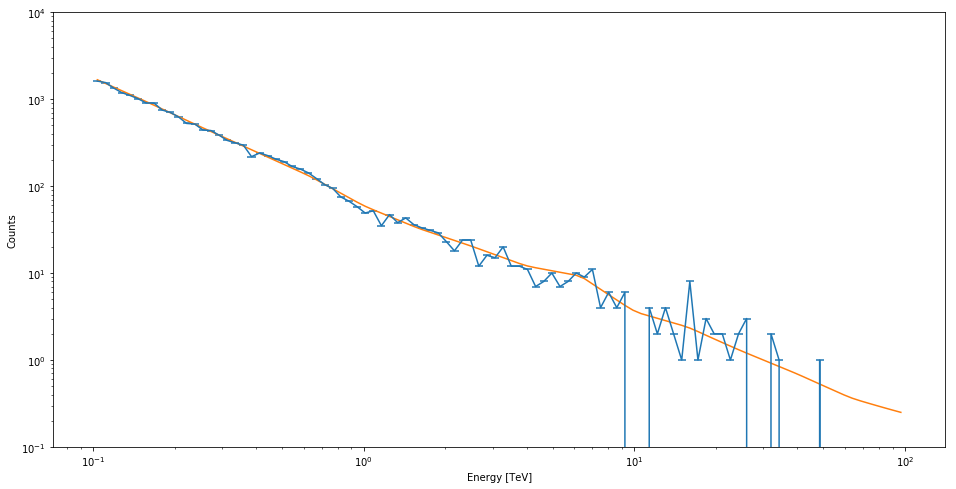

In [9]:
plt.figure(figsize=(16, 8))
spec_npred = bkg.data.sum(axis=-1).sum(axis=-1)
ax = events_bkg.plot_energy(ebounds=energy_axes.edges * energy_axes.unit)
ax.loglog(energy_axes.center, spec_npred)
ax.set_ylim(0.1, 10000)

# Minimal Example with Power-Law

In [10]:
from gammapy.irf import Background3D
from gammapy.spectrum.models import PowerLaw2

In [11]:
energy_axes = MapAxis.from_bounds(0.1, 100, nbin=10, unit='TeV', name='energy', interp='log')
pwl = PowerLaw2(amplitude='1 s-1 sr-1', emin='0.1 TeV', emax='100 TeV')

kwargs = {}
kwargs['fov_lat_hi'] = [0, 0.5] * u.deg
kwargs['fov_lat_lo'] = [-0.5, 0] * u.deg

kwargs['fov_lon_hi'] = [0, 0.5] * u.deg
kwargs['fov_lon_lo'] =  [-0.5, 0] * u.deg

kwargs['energy_hi'] = energy_axes.edges[1:] * energy_axes.unit
kwargs['energy_lo'] = energy_axes.edges[:-1] * energy_axes.unit

energies = energy_axes.center * energy_axes.unit
kwargs['data'] = np.ones((2, 2)) * pwl(energies)[:, np.newaxis, np.newaxis]

bkg_model = Background3D(**kwargs)

In [12]:
energy_axes = MapAxis.from_bounds(0.1, 100, nbin=100, unit='TeV', name='energy', interp='log')
skydir = SkyCoord(0, 0, frame='galactic', unit='deg')
geom = WcsGeom.create(skydir=skydir, width=5 * u.deg, coordsys='GAL', binsz=0.1, axes=[energy_axes])

In [13]:
bkg = make_map_background_irf(
    pointing=skydir,
    livetime=0.5 * u.h,
    bkg=bkg_model,
    geom=geom,
    n_integration_bins=10)

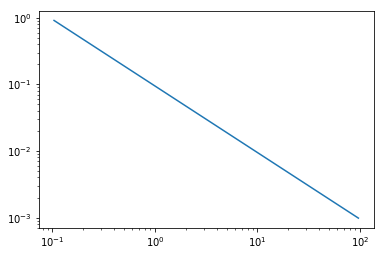

In [14]:
spec = bkg.data.sum(axis=-1).sum(axis=-1)
plt.loglog(energy_axes.center, spec)
